In [1]:
using Revise; 
includet("TrajModules.jl")
using .atom_class
using .SystemSetup
using .utils
using .BeamClass
using .CoolTrap

In [3]:
using DifferentialEquations

In [7]:
using ProfileView
using BenchmarkTools
using PyPlot

In [4]:


function createSystem()
    BField(x, y, z) = 800E-4 * [0, 0, 1]
    atomType = cesiumAtom
    OurSystem = System(atomType, BField, -4e-6:0.4e-7:4e-6)
    return OurSystem
end
function createLight!(OurSystem)
    #clear_beams(OurSystem)
    stateF = (6, 1, 1.5, 5, 5)
    stateI = (6, 0, 0.5, 4, 4)
    detuning = 3e6
    I_mot = 14
    beamAngle = 45 * pi / 180


    println("Setting up MOT")
    updates0 = false
    LocAll::Vector{Float64} = [0, 0, 0]
    set_MOT(OurSystem, BeamProperties(LocAll, [-1.0, 0.0, 0.0], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot, updates0)
    set_MOT(OurSystem, BeamProperties(LocAll, [1.0, 0.0, 0.0], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)
    #R1
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, sin(beamAngle), cos(beamAngle)], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot,updates0)
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, -sin(beamAngle), -cos(beamAngle)], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)
    #R2
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, -sin(beamAngle), cos(beamAngle)], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot, updates0)
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, sin(beamAngle), -cos(beamAngle)], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)

    println("Setting up Tweezer")

    #Tweezer
    stateI_T = (6, 1, 1 / 2)
    stateF_T = (6, 0, 1 / 2)
    wavelength_tweezer = 1064E-9
    trapR, trapZ = 2 * pi * 0.150e6, 2 * pi * 0.029e6

    set_tweezer(OurSystem, BeamProperties(LocAll, [0.0, 0.0, 1.0], pol_v["pi"]), stateI_T, stateF_T, wavelength_tweezer, trapR, trapZ)
    #join_Beams(OurSystem)
end

OurSystem = createSystem()
createLight!(OurSystem);


Setting up MOT


Fixing


Fixing
Setting up Tweezer


In [15]:
using Revise; 
includet("TrajModules.jl")
using .atom_class
using .SystemSetup
using .utils
using .BeamClass
using .CoolTrap

┌ Error: Failed to revise /Users/jluke/Desktop/Simulation/HighFieldImaging/TrajModules.jl
│   exception = (LoadError("/Users/jluke/Desktop/Simulation/HighFieldImaging/TrajModules.jl", 594, "incomplete: \"module\" at /Users/jluke/Desktop/Simulation/HighFieldImaging/TrajModules.jl:418 requires end"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000299700733])
└ @ Revise /Users/jluke/.julia/packages/Revise/7HQ7u/src/packagedef.jl:725
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /Users/jluke/Desktop/Simulation/HighFieldImaging/TrajModules.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.
└ @ Revise /Users/jluke/.julia/packages/Revise/7HQ7u/src/packagedef.jl:833


In [7]:
threadCount(OurSystem)

10

In [5]:
function simulate(u0, param, RHS)

    boundMin, boundMax = minimum(OurSystem.Environment.grid[1]), maximum(OurSystem.Environment.grid[1])
    conditionStop(y, t, integrator) = !any(boundMin + 1e-6 .< y[1:3]) || !any(y[1:3] .< boundMax - 1e-6)
    affect!(integrator) = terminate!(integrator)
    cb = DiscreteCallback(conditionStop, affect!)

    tspan = (0, 1e-6)
    prob = ODEProblem(RHS, u0, tspan, param)
    dt = 2e-9
    sol = solve(prob, RK4(),  save_everystep = false, dt=dt, adaptive=false)#, callback=cb, abstol=1e-3, reltol=1e-3)
    return sol.t, hcat(sol.u...)
end


simulate (generic function with 1 method)

In [9]:
using StaticArrays

In [11]:

u0, param, RHS! = InitializeProblem(OurSystem, 1, 1e-6, "Fabs_spont_R", opt_args=0.0);

@code_warntype t, u = simulate(u0, param, RHS!)
#x, y, z, vx, vy, vz = u[1, :],  u[2, :],  u[3, :],  u[4, :], u[5, :], u[6, :];

ErrorException: expression is not a function call, or is too complex for @code_warntype to analyze; break it down to simpler parts if possible. In some cases, you may want to use Meta.@lower.

In [23]:
using StaticArrays

u0 = [-7.856056780132389e-10, 1.2300091062051335e-9, -2.1800560931297977e-9, -0.003660626169842217, -0.000345860195726146, -0.004419182154000644]
u0_static = SVector{6}(u0)


6-element SVector{6, Float64} with indices SOneTo(6):
 -7.856056780132389e-10
  1.2300091062051335e-9
 -2.1800560931297977e-9
 -0.003660626169842217
 -0.000345860195726146
 -0.004419182154000644

In [34]:
length(t)

501

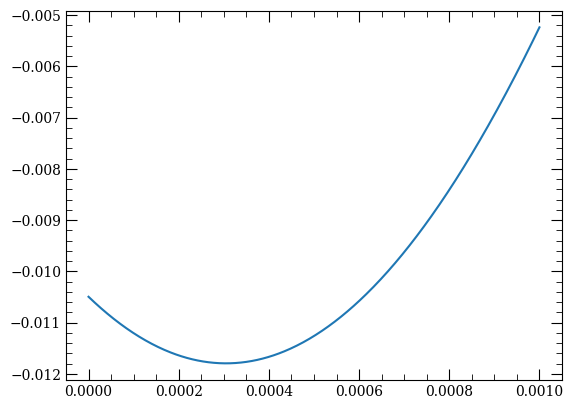

In [35]:


fig = plt.figure()
plot(t*1e3, y*1e6)

#xlim([0, 1e-3])

fig


In [373]:
using Random
a = [1, 2, 3, 4, 5]
b = randn(length(a))
println(findfirst(a .> b))

1


In [68]:
push!(tupl3, 2)

MethodError: MethodError: no method matching push!(::Tuple{Int64, Int64, Int64, String}, ::Int64)
Closest candidates are:
  push!(::Any, ::Any, !Matched::Any) at abstractarray.jl:3059
  push!(::Any, ::Any, !Matched::Any, !Matched::Any...) at abstractarray.jl:3060
  push!(!Matched::DataStructures.DisjointSets{T}, ::T) where T at ~/.julia/packages/DataStructures/CvTHU/src/disjoint_set.jl:230
  ...

In [339]:
a = [1, 2, 3, 2]
b = rand(length(a))
inds = findall(a .> b)
argmax(a[inds])

3

# SPEED

In [13]:
MOT_Test = OurSystem.MOTConfig[1]

MOT_Beam{Float64}(2.2099411934454452e15, 3.0e6, [-7.37142281580863e6, 0.0, 0.0], 3.281495681821934e7, 3.281495681821934e7, 11.023700310506518, GaussianBeam(BeamProperties{Vector{Float64}}([0.0, 0.0, 0.0], [-1.0, 0.0, 0.0], ComplexF64[0.7071067811865475 + 0.0im, 0.0 - 0.7071067811865475im, 0.0 + 0.0im], 1.0e10, 1.0e10), 14.0, 2.2099411964454452e15), Main.CoolTrap.var"#2#8"{Float64}(0.3174977458942898), Environment_T(Any[[0.5369241691980856 0.5722739059351407 … 0.5722739059351407 0.5369241691980856; 0.5722739059351407 0.6104284527223567 … 0.6104284527223567 0.5722739059351407; … ; 0.5722739059351407 0.6104284527223567 … 0.6104284527223567 0.5722739059351407; 0.5369241691980856 0.5722739059351407 … 0.5722739059351407 0.5369241691980856;;; 0.5416457853041334 0.5773063813689993 … 0.5773063813689993 0.5416457853041334; 0.5773063813689993 0.6157964524871437 … 0.6157964524871437 0.5773063813689993; … ; 0.5773063813689993 0.6157964524871437 … 0.6157964524871437 0.5773063813689993; 0.54164578530

In [14]:
@code_warntype get_Fnet(MOT_Test, [0.0, 0, 0], [0.0, 0, 0])

MethodInstance for Main.CoolTrap.get_Fnet(::MOT_Beam{Float64}, ::Vector{Float64}, ::Vector{Float64})
  from get_Fnet(MBeam::MOT_Beam, pos, vel) in Main.CoolTrap at /Users/jluke/Desktop/Simulation/HighFieldImaging/TrajModules.jl:237


Arguments
  #self#::Core.Const(Main.CoolTrap.get_Fnet)


  MBeam::MOT_Beam{Float64}
  pos::Vector{Float64}
  vel::Vector{Float64}
Body::Any


1 ─ %1 = Core

.typeassert(MBeam, Main.CoolTrap.MOT_Beam)::MOT_Beam{Float64}


│   %2 = Main.CoolTrap.get_Fnet(%1, pos, vel, 0)::Any
└──      return %2

